Imports

In [1]:
import pandas as pd
import pyarrow.parquet as pq
from sklearn.metrics import classification_report
RANDOM_SEED = 42
batch_size = 1000000

In [2]:
df = pd.read_parquet("/kaggle/input/competicion-q-no-me-deja-sino/data/train.parquet")
print(df.shape)
df.head()

(14728321, 89)


,id,channel_1,channel_10,channel_11,channel_12,channel_13,channel_14,channel_15,channel_16,channel_17,...,telecommand_351,telecommand_352,telecommand_353,telecommand_354,telecommand_36,telecommand_376,telecommand_38,telecommand_39,telecommand_40,is_anomaly
0,0,0.13791,0.0,0.0,0.317175,0.371764,0.297205,0.130113,0.766769,0.349474,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1,0.13791,0.0,0.0,0.317175,0.371764,0.297205,0.130113,0.766769,0.349474,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2,0.13791,0.0,0.0,0.317175,0.371764,0.297205,0.130113,0.766769,0.349474,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,3,0.13791,0.0,0.0,0.317175,0.371764,0.297205,0.130113,0.766769,0.349474,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,4,0.13791,0.0,0.0,0.317175,0.371764,0.297205,0.130113,0.766769,0.349474,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [3]:
# empezamos usando solo las columnas que segun los creadores mejor funcionan
best_channels = ["channel_41","channel_42","channel_43","channel_44","channel_45","channel_46"]
reduced_df = df[best_channels + ['is_anomaly','id']].copy()

In [4]:
# printeamos ids de cuando hay anomalias
print(reduced_df[reduced_df['is_anomaly'] == 1]['id'])

115383        115383
115384        115384
115385        115385
115386        115386
115387        115387
              ...   
14654248    14654248
14654249    14654249
14654250    14654250
14654251    14654251
14654252    14654252
Name: id, Length: 1544104, dtype: int64


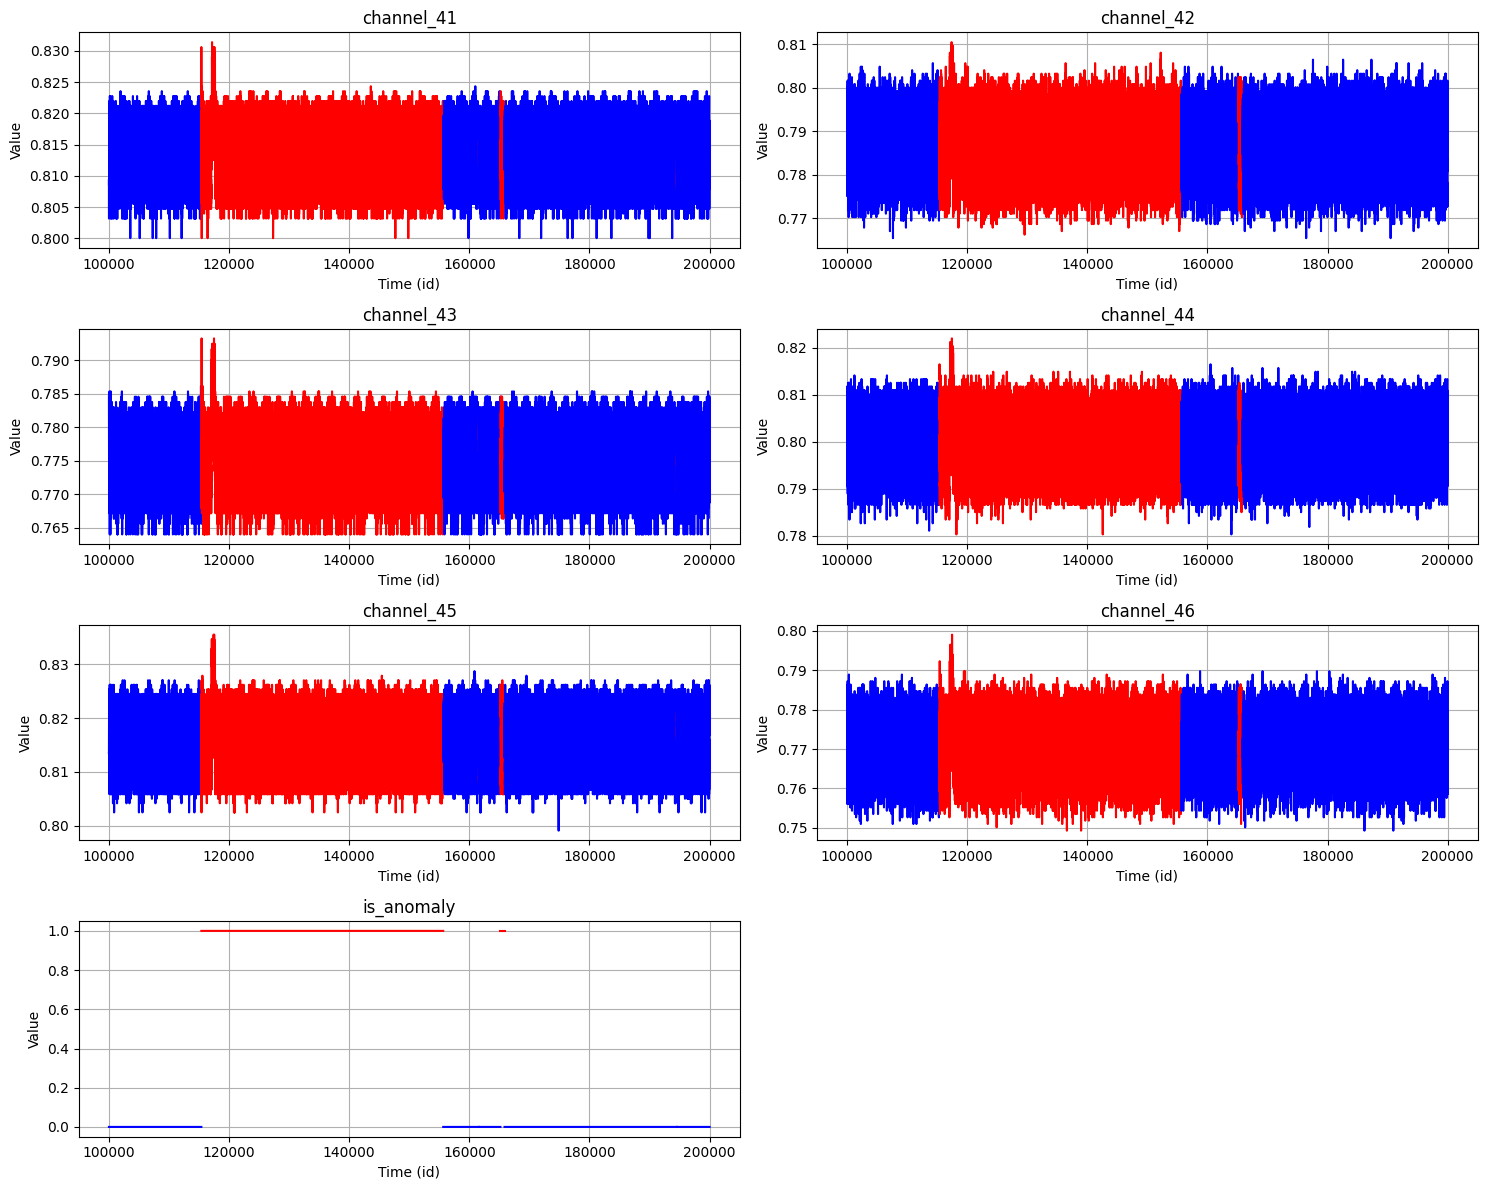

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def draw_temporal_channels(df, draw_channels, id_start=100000, id_end=200000,plot_anomaly = True):
    # Filter DataFrame
    filtered_df = df[(df["id"] >= id_start) & (df["id"] <= id_end)].copy()
    filtered_df = filtered_df[["id"] + [ch for ch in draw_channels if ch not in {'id', 'is_anomaly'}] + ['is_anomaly']].sort_values("id")
    
    if plot_anomaly:
        draw_channels = draw_channels + ['is_anomaly']
    
    rows = (1 + len(draw_channels)) // 2
    plt.figure(figsize=(15, max(10, rows * 3)))

    # Plot each channel with color change on anomaly
    for i, channel in enumerate(draw_channels, 1):
        plt.subplot(rows, 2, i)
        ids = filtered_df["id"].values
        values = filtered_df[channel].values
        anomalies = filtered_df["is_anomaly"].values.astype(bool)

        # Identify contiguous regions with same anomaly label
        change_points = np.where(np.diff(anomalies))[0] + 1
        segments = np.split(np.arange(len(filtered_df)), change_points)

        for seg in segments:
            color = 'red' if anomalies[seg[0]] else 'blue'
            plt.plot(ids[seg], values[seg], color=color)

        plt.title(channel)
        plt.xlabel("Time (id)")
        plt.ylabel("Value")
        plt.grid(True)

    plt.tight_layout()
    plt.show()


# Use only signal channels
draw_channels = best_channels
draw_temporal_channels(df, draw_channels, id_start=100000, id_end=200000)


Parece que cerca de la primera anomalia existe un outlier en todos los canales vamos a observar mas de cerca

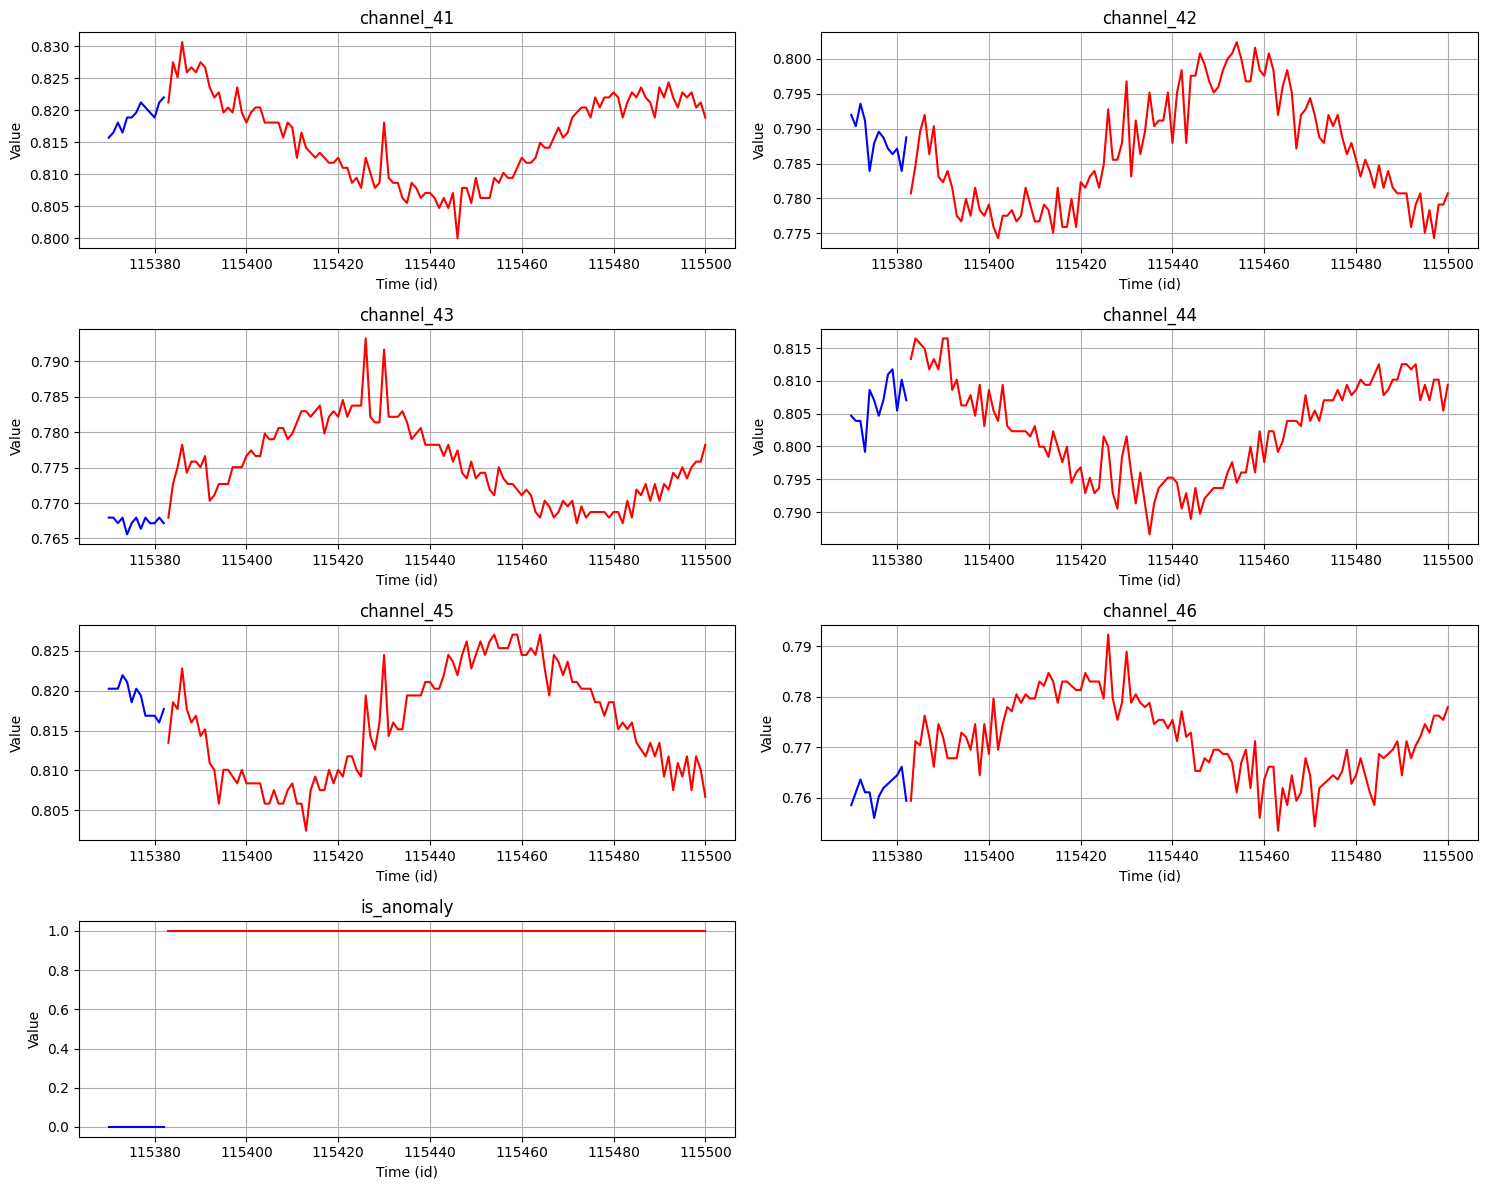

In [20]:
draw_temporal_channels(df,draw_channels,id_start=115370,id_end=115500)

Observando mas de cerca no parece tan evidente que haya habido un outlier excepto por el channel 41

Vemos que sucede al "acabar la anomalia cerca de 150000 con todas las variables para ver si en alguna es evidente el cambio.

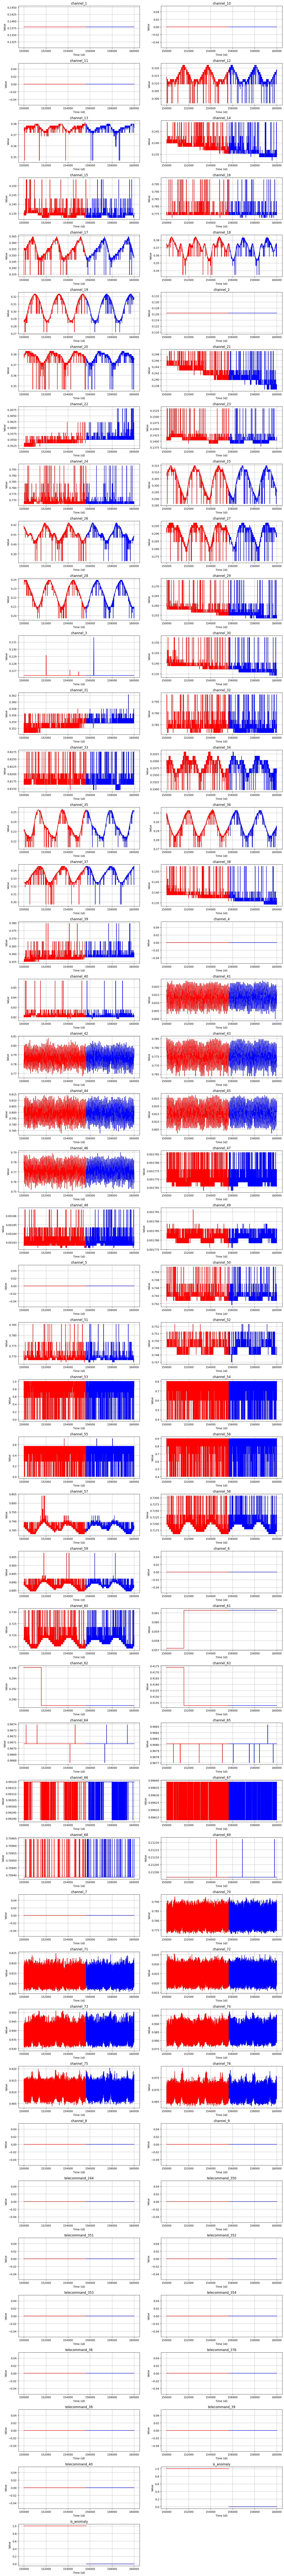

In [21]:
draw_temporal_channels(df,df.columns.values[1:].tolist(),id_start=150000,id_end=160000)

Tampoco parece haber un cambio o outlier evidente cuando se termina la anomalia, por ello es evidente que se necesitan enfoques mas complejos para detectar las anomalias.

Probamos cosas. Por falta de RAM unicamente usamos un dataset reducido

In [23]:
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn

# variables 
best_channels = ["channel_41","channel_42","channel_43","channel_44","channel_45","channel_46"]
label_col = 'is_anomaly'

stride = 10
input_dim = len(best_channels)

In [24]:
# definimos el modelo
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x).squeeze(1)  # output shape: (batch,)
        
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BinaryClassifier(input_dim).to(device)

In [25]:
# cargamos los datos
from sklearn.model_selection import train_test_split

X = torch.tensor(df[best_channels].values, dtype=torch.float32)  # [timesteps, input_dim]
y = torch.tensor(df[label_col].values, dtype=torch.float32)        # [timesteps]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)


train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32)

In [38]:
import numpy as np
from scipy.ndimage import label

def get_segments(y):
    """Returns array of (start_idx, end_idx) for continuous 1s."""
    labeled, num_features = label(y)
    if num_features == 0:
        return np.empty((0, 2), dtype=int)
    bounds = np.array([np.where(labeled == i)[0][[0, -1]] for i in range(1, num_features + 1)])
    return bounds

def corrected_f05_score(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    assert y_true.shape == y_pred.shape

    true_segments = get_segments(y_true)
    pred_segments = get_segments(y_pred)

    matched_true = np.zeros(len(true_segments), dtype=bool)
    TP_e = 0

    for ps_start, ps_end in pred_segments:
        overlaps = (ps_end >= true_segments[:, 0]) & (ps_start <= true_segments[:, 1])
        match_indices = np.where(overlaps & ~matched_true)[0]
        if match_indices.size > 0:
            matched_true[match_indices[0]] = True
            TP_e += 1

    FP_e = len(pred_segments) - TP_e
    FN_e = len(true_segments) - TP_e

    FP_t = np.sum((y_pred == 1) & (y_true == 0))
    N_t = np.sum(y_true == 0)

    precision_e_corr = 0 if (TP_e + FP_e) == 0 else (TP_e / (TP_e + FP_e)) * (1 - FP_t / N_t)
    recall_e = 0 if (TP_e + FN_e) == 0 else TP_e / (TP_e + FN_e)

    beta_sq = 0.25
    denom = beta_sq * precision_e_corr + recall_e
    f_beta = 0 if denom == 0 else (1 + beta_sq) * (precision_e_corr * recall_e) / denom

    return f_beta


In [39]:
# definimos el metodo de entrenamiento y evaluacion
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)  # y: [batch, seq_len]

        optimizer.zero_grad()
        logits = model(x)  # [batch, seq_len, num_classes]
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)


def evaluate(model, loader):
    model.eval()
    y_preds, y_trues = [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            outputs = model(X_batch)
            preds = torch.sigmoid(outputs) > 0.5
            y_preds.extend(preds.cpu().numpy())
            y_trues.extend(y_batch.cpu().numpy())
    print(f"corrected event-wise F0.5 score for anomaly detection in time series: {corrected_f05_score(y_trues,y_preds)}")


In [41]:
import torch.optim as optim
labels  = df[label_col]
lass_counts = labels.value_counts()
class_counts = labels.value_counts()

# Como queremos miminizar los falsos positivos usamos estos pesos de la funcion de perdida
pos_weight = torch.tensor([2.0])  # favors precision
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)


optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
for epoch in range(10):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    print(f"Epoch {epoch+1}, train loss: {train_loss}, evaluation:")
    evaluate(model, val_loader)


Epoch 1, train loss: 0.5127530480520395, evaluation:
corrected event-wise F0.5 score for anomaly detection in time series: 0.3015682702385329
Epoch 2, train loss: 0.5106710844838696, evaluation:
corrected event-wise F0.5 score for anomaly detection in time series: 0.31770987837436965
Epoch 3, train loss: 0.5106289251455167, evaluation:
corrected event-wise F0.5 score for anomaly detection in time series: 0.31898534409858936


KeyboardInterrupt: 

Podemos observar como no se obtienen muy buenos resultados, obteniendo un fscore que apenas supera el 0.5, debido a que el modelo aprende a predecir siempre la clase 0 no anomalia.

Vamos a probar a usar un sliding window con la media de datos como entrada.

In [42]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Apply sliding window (mean of previous 20 values)
window_size = 20
df_smooth = df.copy()
df_smooth[best_channels] = df[best_channels].rolling(window=window_size, min_periods=1).mean()

# Convert to tensors
X = torch.tensor(df_smooth[best_channels].values, dtype=torch.float32)  # [timesteps, input_dim]
y = torch.tensor(df[label_col].values, dtype=torch.float32)             # [timesteps]

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)

# Create data loaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32)


In [ ]:
import torch.optim as optim
labels  = df[label_col]
lass_counts = labels.value_counts()
class_counts = labels.value_counts()

# Como queremos miminizar los falsos positivos usamos estos pesos de la funcion de perdida
pos_weight = torch.tensor([0.2])  # favors precision
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)


optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
for epoch in range(10):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    print(f"Epoch {epoch+1}, train loss: {train_loss}, evaluation:")
    evaluate(model, val_loader)

In [ ]:
!pip install tsai
!pip install scikit-learn==1.3.2
